# Compare different scenarios 

In [1]:
import matplotlib.pyplot as plt
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import model.base_inputs as inp
import experiments.multi_scenario_comparison as msc
import plot.scenario_comparison as plt_sc
import imp
import numpy as np
import pickle
import copy
imp.reload(mod_code)

<module 'model.model' from '/home/twilliams/adaptation_abm/code/model/model.py'>

## Define scenarios 

In [130]:
# load default params
inp_base = inp.compile()
#### OR ####
# load from POM experiment
f = '../../outputs/2019_10_15_4/POM/100000_10reps/input_params_0.pkl'
inp_base = pickle.load(open(f, 'rb'))

# manually specify some variables (common to all scenarios)
inp_base['model']['T'] = 10 + inp_base['adaptation']['burnin_period']
inp_base['model']['n_agents'] = 300
inp_base['model']['exp_name'] = 'scenario_compare'
inp_base['agents']['adap_type'] = 'always'
inp_base['model']['seed'] = 0
# things not in the POM
inp_base['agents']['land_area_multiplier'] = 1

# define some scenarios
## adaptation scenarios
scenarios = {
    'baseline' : {'model' : {'adaptation_option' : 'none'}},
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}

## Run the model

In [140]:
nreps = 60000
ncores = 40
mods = msc.multi_mod_run(nreps, inp_base, scenarios, ncores)

## SOM and wealth trajectories

Text(-0.4, 1.15, 'Cover crop')

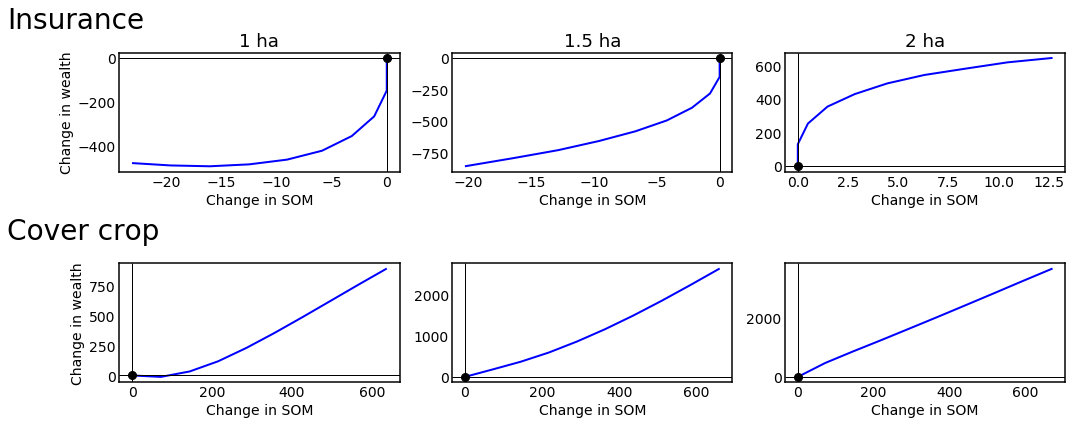

In [141]:
fig, axs = plt.subplots(2,3, figsize=(15,6))
pols = ['insurance', 'cover_crop']

for l, land_area in enumerate([1,1.5,2]):
    
    for p, pol in enumerate(pols):
        ax = axs[p,l]
        ## format the data
        areas = mods['baseline']['land_area'] == land_area
        som = np.swapaxes(mods[pol]['organic'] - mods['baseline']['organic'], 0, 1)
        som = np.mean(som[:,areas], axis=1)
        wealth = np.swapaxes(mods[pol]['wealth'] - mods['baseline']['wealth'], 0, 1)
        wealth = np.mean(wealth[:,areas], axis=1)

        # plot
        ax.plot(som, wealth, label=pol, lw=2)
        ax.plot(0,0, marker='o', color='k', markersize=8)

        ax.grid(False)
        ax.axhline(0, color='k', lw=1)
        ax.axvline(0, color='k', lw=1)
        
        if l == 0:
            ax.set_ylabel('Change in wealth')
        if p == 0:
            ax.set_title('{} ha'.format(land_area))
        ax.set_xlabel('Change in SOM')
    
axs[0,0].text(-0.4, 1.15, 'Insurance', transform=axs[0,0].transAxes, fontsize=28, va='bottom')
axs[1,0].text(-0.4, 1.15, 'Cover crop', transform=axs[1,0].transAxes, fontsize=28, va='bottom')

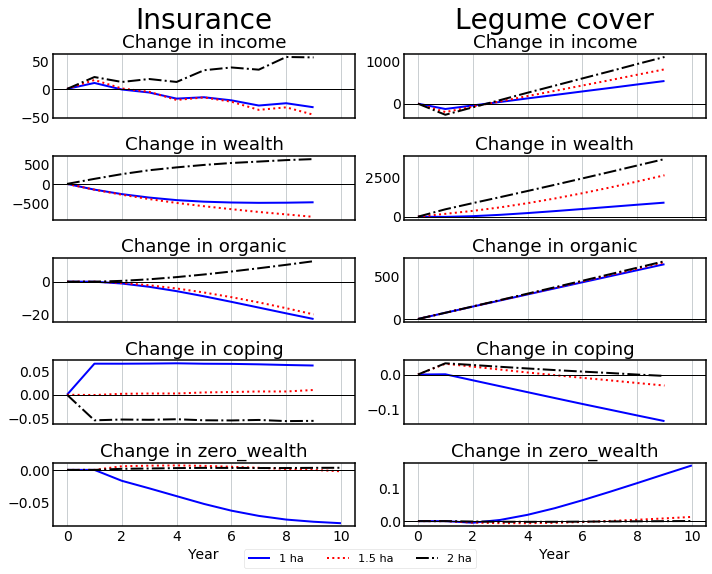

In [143]:
fig, axs = plt.subplots(5,2, figsize=(10,8), sharex=True)
pols = ['insurance', 'cover_crop']
land_areas = [1, 1.5, 2]
ltys = ['-',':','-.']

for o, outcome in enumerate(['income','wealth','organic','coping', 'zero_wealth']):
    for p, pol in enumerate(pols):
        ax = axs[o,p]
        for l, land_area in enumerate(land_areas):
            ## format the data
            areas = mods['baseline']['land_area'] == land_area
            if outcome != 'zero_wealth':
                data = np.swapaxes(mods[pol][outcome].astype(float) - mods['baseline'][outcome].astype(float), 0, 1)
                data = np.mean(data[:,areas], axis=1)
            else:
                data = np.swapaxes((mods[pol]['wealth']>0).astype(float) - (mods['baseline']['wealth']>0).astype(float), 0, 1)
                data = np.mean(data[:,areas], axis=1)
                
            # plot
            start = 11 if outcome in ['wealth','organic'] else 10
            ax.plot(data[start:], lw=2, label='{} ha'.format(land_area), ls=ltys[l])

            ax.axhline(0, color='k', lw=1, label='_nolegend_')
            ax.set_title('Change in {}'.format(outcome))
            ax.grid(False, axis='y')
    
axs[-1,0].set_xlabel('Year')
axs[-1,1].set_xlabel('Year')
axs[0,0].text(0.5, 1.3, 'Insurance', va='bottom', ha='center', fontsize=28, transform=axs[0,0].transAxes)
axs[0,1].text(0.5, 1.3, 'Legume cover', va='bottom', ha='center', fontsize=28, transform=axs[0,1].transAxes)
lg = fig.legend([str(li) + ' ha' for li in land_areas], ncol=3, bbox_to_anchor=[0.5, 0], loc='lower center')

## change in insurance price : effect on middle agent